In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_excel('/Users/jatindhurve/Desktop/Regime_Portfolio_project/Data/leading_indicators.xlsx')

In [4]:
df.head(1)

,Date,VIX,PMI,yield_curve
0,1990-01-31,25.36,47.2,16.35


In [5]:
df.tail(1)

,Date,VIX,PMI,yield_curve
422,2025-03-31,22.28,49.0,31.799


In [6]:
df.isna().sum().sum()

0

In [7]:
df.columns

Index(['Date', 'VIX', 'PMI', 'yield_curve'], dtype='object')

In [8]:
features = ["VIX", "PMI", "yield_curve"]
mask     = df[features].notna().all(axis=1)

X      = df.loc[mask, features].values
dates  = df.loc[mask, "Date"].values       
scaler = StandardScaler()
X_std  = scaler.fit_transform(X)

In [9]:
n_states = 4
hmm = GaussianHMM(
    n_components   = n_states,
    covariance_type= "full",
    n_iter         = 1000,
    random_state   = 42,
)
hmm.fit(X_std)
states = hmm.predict(X_std)      

In [10]:
centroids = pd.DataFrame(hmm.means_, columns=features)

In [11]:
mapping = {}

# 1. Expansion → highest PMI & lowest VIX (optional tie-breaker)
expansion_idx = centroids["PMI"].idxmax()
mapping[expansion_idx] = "Expansion"

# 2. Downturn → lowest PMI & highest VIX (optional tie-breaker)
downturn_idx = centroids["PMI"].idxmin()
mapping[downturn_idx] = "Downturn"

# 3. Get remaining states
remaining = [s for s in range(n_states) if s not in mapping]

# 4. Use yield curve to split remaining into Recovery and Slowdown
remaining_df = centroids.loc[remaining]

# Recovery → higher yield curve & lower VIX (steep curve, calmer market)
# Slowdown → flatter curve or higher VIX (risk or uncertainty)
recovery_idx = remaining_df.sort_values(by=["yield_curve", "VIX"], ascending=[False, True]).index[0]
slowdown_idx = [s for s in remaining if s != recovery_idx][0]

mapping[recovery_idx] = "Recovery"
mapping[slowdown_idx] = "Slowdown"

# Map each state number to its regime label
state_labels = [mapping[s] for s in states]

In [12]:
print(centroids.round(2))

    VIX   PMI  yield_curve
0  0.89 -0.64         0.92
1 -0.13  0.48        -0.90
2 -0.63  0.17         0.51
3  0.42 -0.54        -0.91


In [13]:
reg_df = pd.DataFrame({"Date": dates, "regimes": state_labels})
df = df.merge(reg_df, on="Date", how="left")

### **Probabalities**

In [14]:
# Get smoothed probabilities (posterior probabilities for each time point)
smoothed_probs = hmm.predict_proba(X_std)

# Get steady-state probabilities (long-run equilibrium probabilities)
steady_state_probs = hmm.get_stationary_distribution()

# Create dictionary mapping regime names to steady-state probabilities
steady_state_dict = {mapping[i]: steady_state_probs[i] for i in range(n_states)}

print("Steady-State Probabilities:")
for regime, prob in steady_state_dict.items():
   print(f"{regime}: {prob:.3f}")

Steady-State Probabilities:
Downturn: 0.235
Expansion: 0.319
Recovery: 0.338
Slowdown: 0.108


In [15]:
df.head()

,Date,VIX,PMI,yield_curve,regimes
0,1990-01-31,25.36,47.2,16.35,Slowdown
1,1990-02-28,21.99,49.1,9.35,Slowdown
2,1990-03-30,19.73,49.9,0.55,Slowdown
3,1990-04-30,19.52,50.0,7.75,Slowdown
4,1990-05-31,17.37,49.5,11.65,Slowdown


In [16]:
df.to_excel("hmm_regime_identification.xlsx", index=False)

In [17]:
df = (
    df.set_index("Date")         
      .asfreq("M")                
)
df["regimes"] = df["regimes"].ffill().bfill()

# (optional) quick inspection
print(df["regimes"])

Date
1990-01-31    Slowdown
1990-02-28    Slowdown
1990-03-31    Slowdown
1990-04-30    Slowdown
1990-05-31    Slowdown
                ...   
2024-11-30    Slowdown
2024-12-31    Slowdown
2025-01-31    Slowdown
2025-02-28    Slowdown
2025-03-31    Slowdown
Freq: ME, Name: regimes, Length: 423, dtype: object


/var/folders/ky/n1n3tvzn3zb6_44x8nfzwn700000gn/T/ipykernel_27839/2698831533.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .asfreq("M")


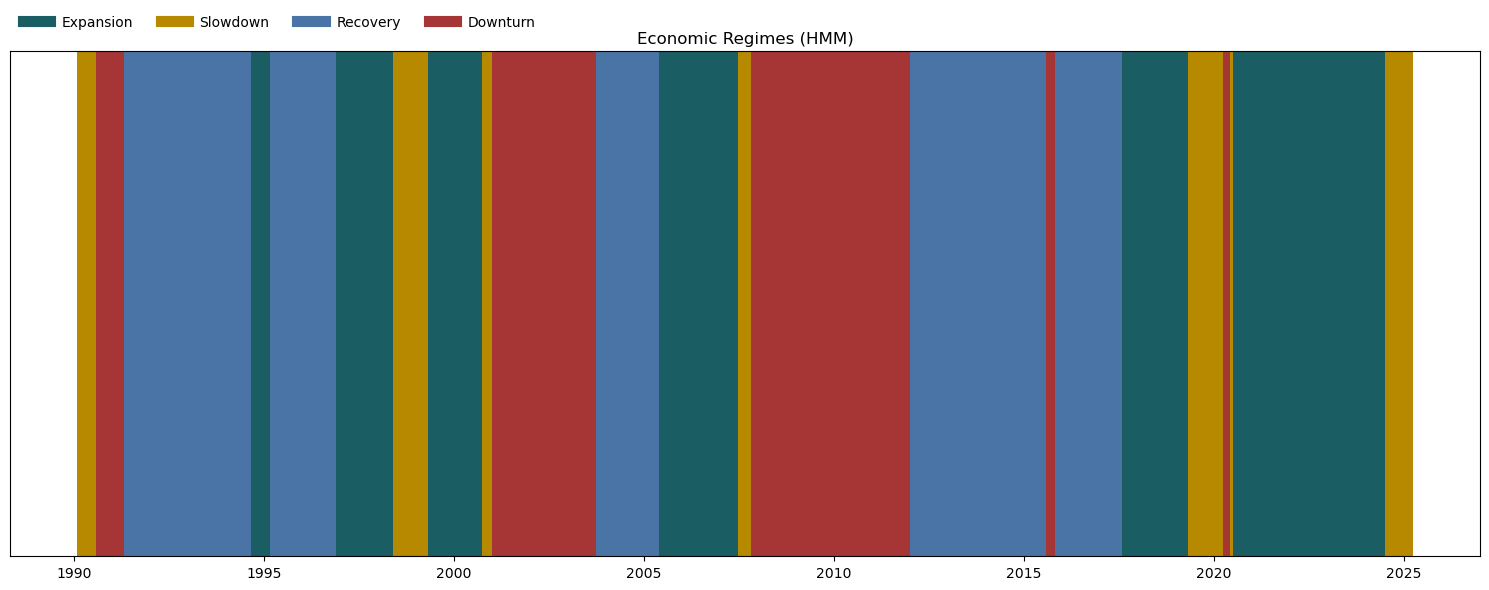

In [18]:
palette = {
    "Expansion": "#1A5E63",
    "Slowdown" : "#B68900",
    "Recovery" : "#4B74A6",
    "Downturn" : "#A63636",
}

fig, ax = plt.subplots(figsize=(15, 6))

segments = (df["regimes"] != df["regimes"].shift()).cumsum()

# Collect spans
spans = []
for _, seg in df.groupby(segments):
    regime = seg["regimes"].iloc[0]
    start = seg.index[0]
    end = seg.index[-1] + pd.offsets.MonthEnd(0)
    spans.append((start, end, regime))

# Fix: Force perfect continuity between spans
for i, (start, end, regime) in enumerate(spans):
    if i > 0:
        # Force current start = previous end
        start = spans[i - 1][1]
    ax.axvspan(start, end, color=palette[regime], lw=0)

# Clean axes
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_title("Economic Regimes (HMM)")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Legend
handles = [plt.Line2D([0], [0], lw=8, color=c) for c in palette.values()]
ax.legend(handles, palette.keys(), ncol=4, frameon=False,
          bbox_to_anchor=(0, 1.02, 1, .2), loc="lower left")

plt.tight_layout()
plt.show()

In [24]:
regime_summary = pd.DataFrame({
    'Observations': df['regimes'].value_counts(),
    'Percentage': df['regimes'].value_counts(normalize=True) * 100,
    'Years': df['regimes'].value_counts() / 12
}).round(2)
print("Table 6.1: Regime Distribution and Sample Characteristics")
print(regime_summary)

Table 6.1: Regime Distribution and Sample Characteristics
           Observations  Percentage  Years
regimes                                   
Recovery            145       34.28  12.08
Expansion           135       31.91  11.25
Downturn             97       22.93   8.08
Slowdown             46       10.87   3.83
